In [31]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from keras.utils import to_categorical

warnings.filterwarnings('ignore')


In [32]:
# Load labels
df = pd.read_csv("patient_diagnosis.csv", header=None, names=["patient_id", "diagnosis"])
print("CSV Loaded. Sample:")
print(df.head())


CSV Loaded. Sample:
   patient_id diagnosis
0         101      URTI
1         102   Healthy
2         103    Asthma
3         104      COPD
4         105      URTI


In [33]:
# Match files with labels
data_dir = "respiratory_sound_data"
ids = df["patient_id"].tolist()
labels = df["diagnosis"].tolist()

dataset = []
for filepath in glob.glob(os.path.join(data_dir, "*.wav")):
    filename = os.path.basename(filepath)
    patient_id = int(filename.split('_')[0])
    if patient_id in ids:
        label = labels[ids.index(patient_id)]
        duration = librosa.get_duration(path=filepath)
        if duration >= 3:
            slice_size = 3
            step = 2  # overlap
            iterations = max(1, int((duration - slice_size) // step))
            for i in range(iterations):
                offset = i * step
                dataset.append({
                    "filename": filepath,
                    "label": label,
                    "offset": offset
                })

dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
print("Dataset Created:")
print(dataset.head())


Dataset Created:
                                               filename label  offset
743   respiratory_sound_data\118_1b1_Lr_sc_Litt3200.wav  COPD      10
4881  respiratory_sound_data\174_1p4_Pr_mc_AKGC417L.wav  COPD      14
4174  respiratory_sound_data\166_1p1_Ar_sc_Meditron.wav  COPD      28
6940  respiratory_sound_data\205_4b2_Pr_mc_AKGC417L.wav  COPD      12
3016  respiratory_sound_data\154_3b3_Al_mc_AKGC417L.wav  COPD      12


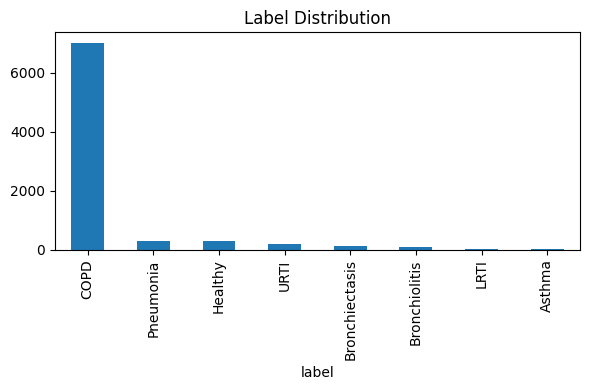

In [34]:
plt.figure(figsize=(6, 4))
dataset['label'].value_counts().plot(kind='bar', title="Label Distribution")
plt.tight_layout()
plt.show()


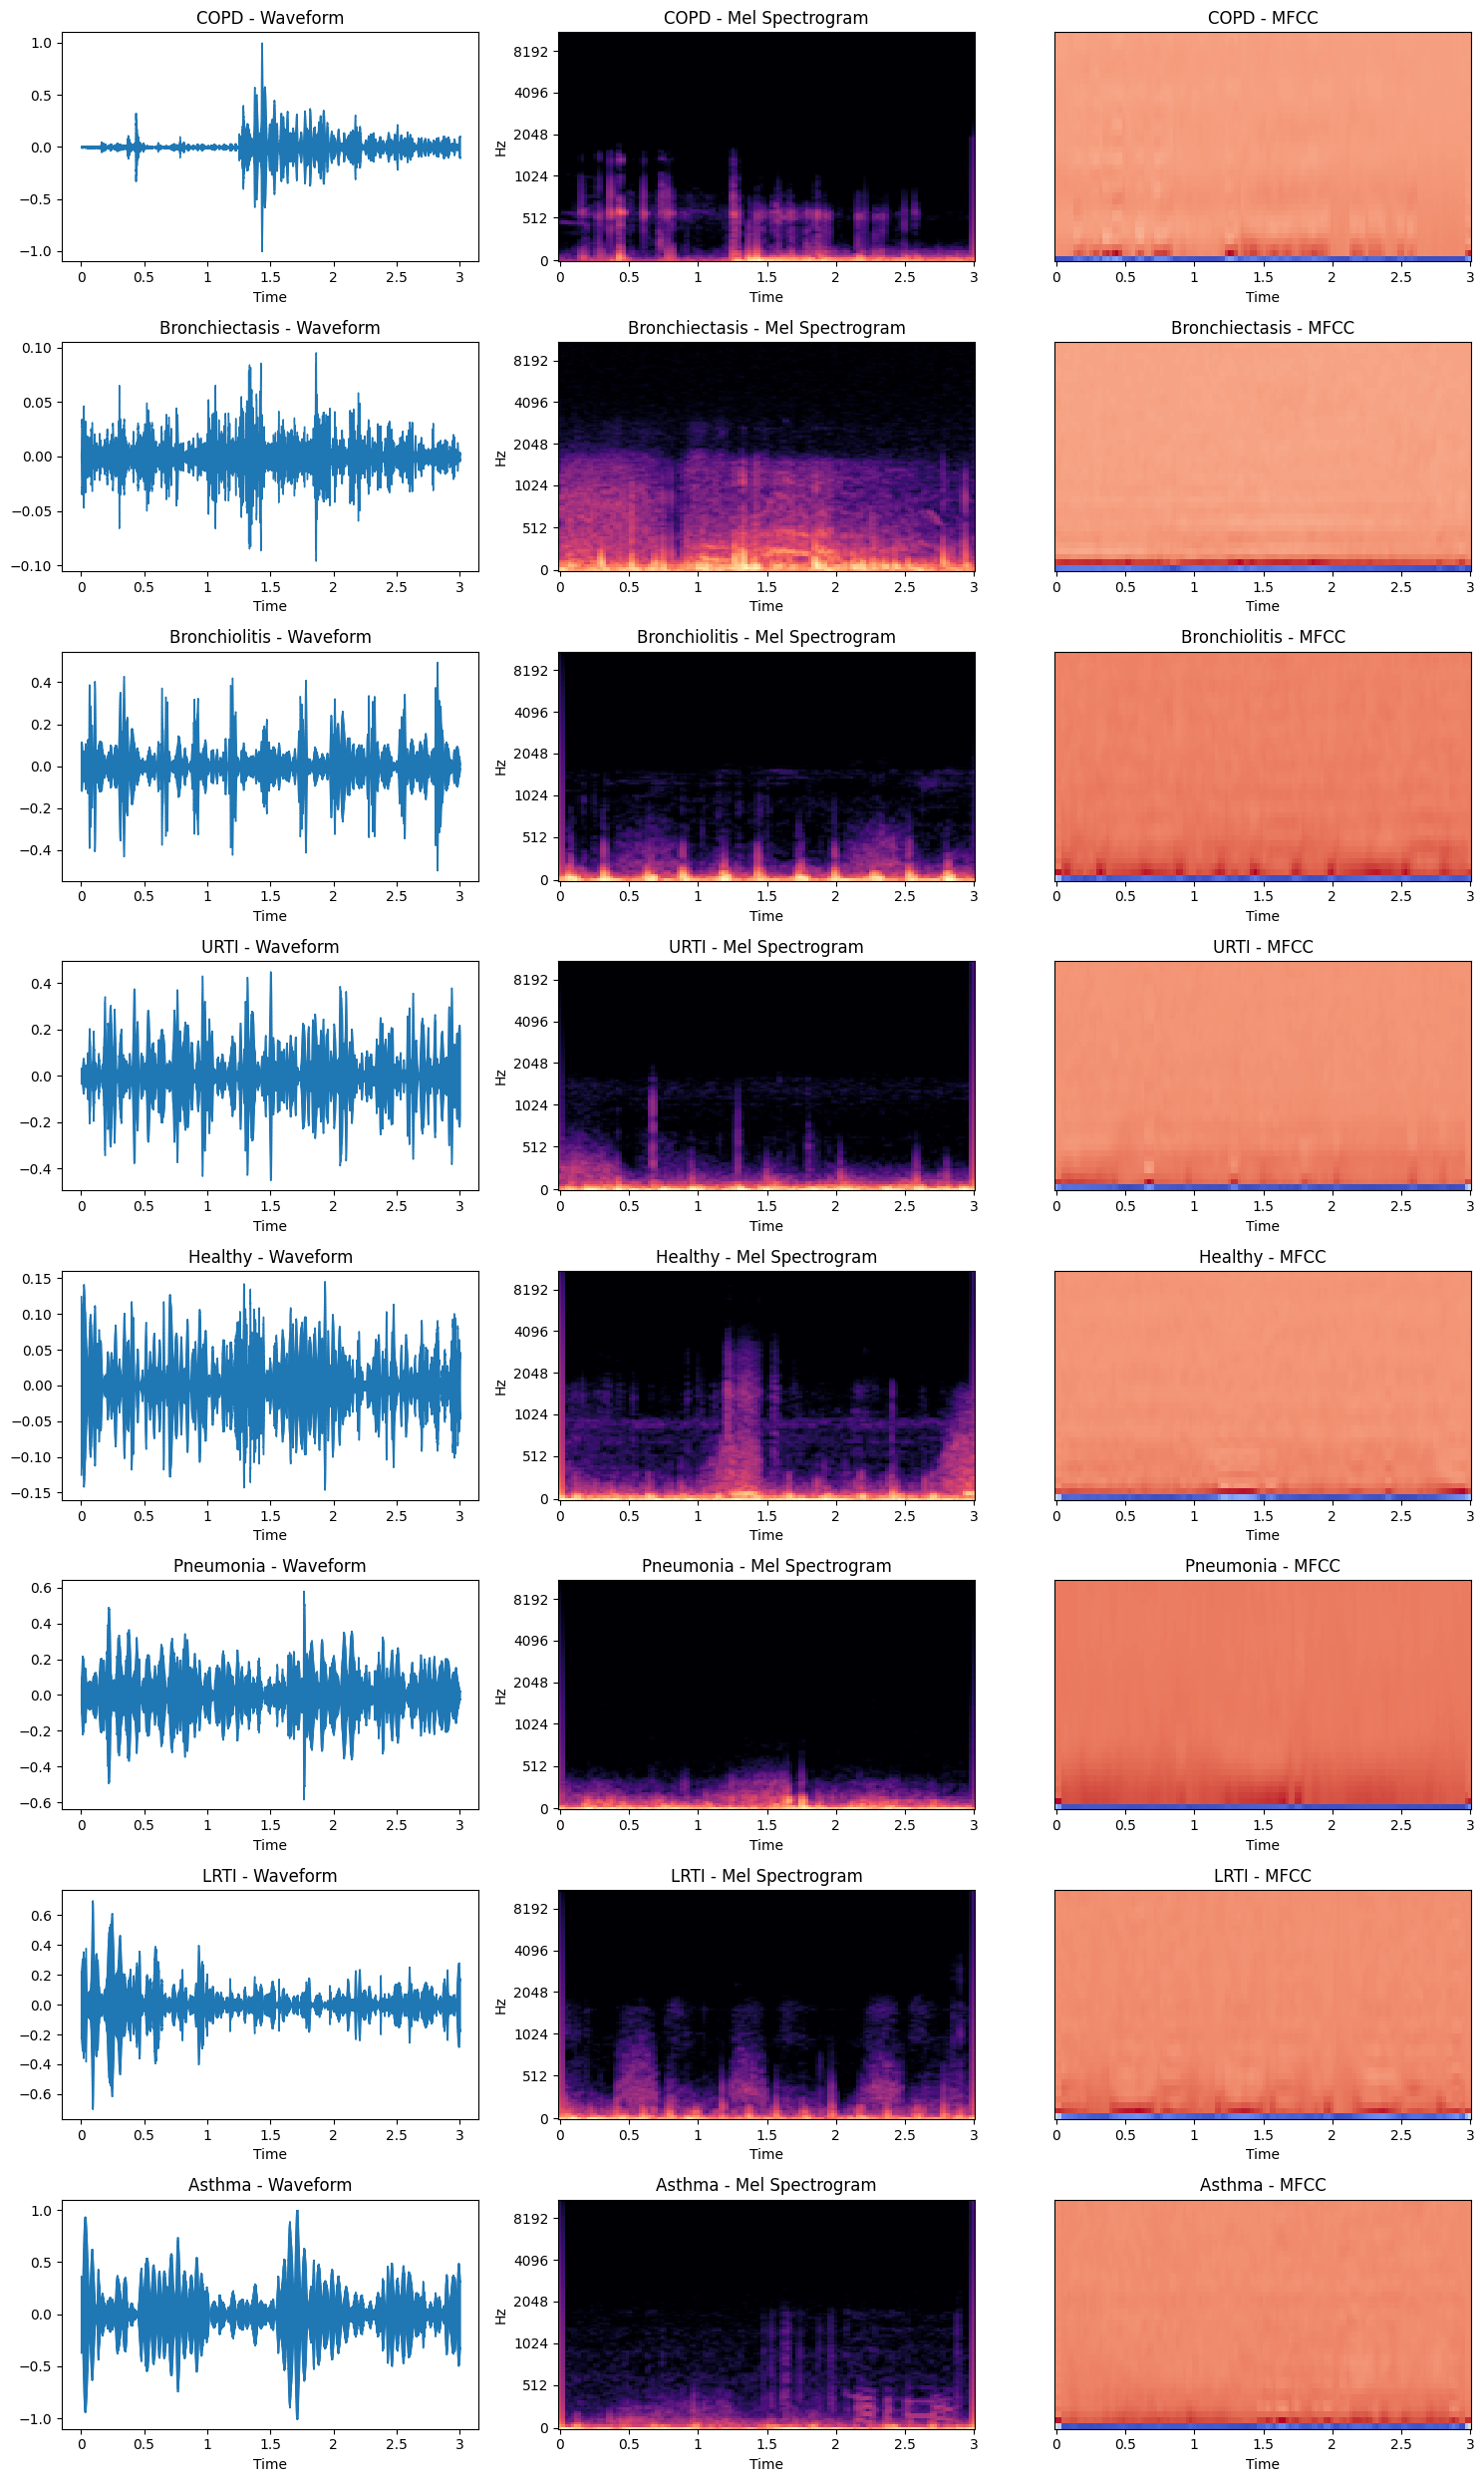

In [35]:
plt.figure(figsize=(15, 25))
idx = 1
for label in dataset.label.unique():
    sample_path = dataset[dataset.label == label].filename.iloc[0]
    y, sr = librosa.load(sample_path, duration=3)

    # Waveform
    plt.subplot(8, 3, idx)
    plt.title(f"{label} - Waveform")
    librosa.display.waveshow(y=y, sr=sr)
    idx += 1

    # Mel Spectrogram
    plt.subplot(8, 3, idx)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"{label} - Mel Spectrogram")
    idx += 1

    # MFCC
    plt.subplot(8, 3, idx)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title(f"{label} - MFCC")
    idx += 1

plt.tight_layout()
plt.show()


In [36]:
def extract_features(path, offset):
    y, sr = librosa.load(path, offset=offset, duration=3)
    y = librosa.util.normalize(y)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    return mfccs


In [37]:
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

x_train, x_test = [], []
for i in tqdm(range(len(train_df)), desc="Extracting Train"):
    x_train.append(extract_features(train_df.iloc[i].filename, train_df.iloc[i].offset))
for i in tqdm(range(len(test_df)), desc="Extracting Test"):
    x_test.append(extract_features(test_df.iloc[i].filename, test_df.iloc[i].offset))

x_train = np.array(x_train)
x_test = np.array(x_test)


Extracting Test: 100%|█████████████████████████████████████████████████████████████| 1609/1609 [02:11<00:00, 12.21it/s]


In [38]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df.label)
y_test = encoder.transform(test_df.label)

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [39]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df.label)
y_test = encoder.transform(test_df.label)

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [40]:
model = Sequential([
    Conv2D(16, kernel_size=2, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(32, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(64, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Conv2D(128, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.5),

    GlobalAveragePooling2D(),
    Dense(len(encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 39, 129, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 63, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 31, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 31, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 30, 64)           │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 15, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 15, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 14, 128)          │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,344 (173.22 KB)

 Trainable params: 44,344 (173.22 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_test, y_test),
    shuffle=True,
    class_weight=class_weights
)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.1127 - loss: 9.7991 - val_accuracy: 0.1193 - val_loss: 2.0395
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1679 - loss: 2.2762 - val_accuracy: 0.5550 - val_loss: 1.6982
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1937 - loss: 1.9478 - val_accuracy: 0.8042 - val_loss: 1.2991
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3325 - loss: 1.8543 - val_accuracy: 0.7557 - val_loss: 1.2886
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3785 - loss: 1.7732 - val_accuracy: 0.7980 - val_loss: 1.2284
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3023 - loss: 1.8639 - val_accuracy: 0.8198 - val_loss: 1.2001
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3826 - loss: 1.5578 - val_accuracy: 0.5786 - val_loss: 1.2049
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3790 - loss: 1.6369 - val_accuracy: 0.7632 - v

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)


In [ ]:
history=model.fit(x_train,y_train,batch_size=128,epochs=300,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8707 - loss: 0.3705 - val_accuracy: 0.9316 - val_loss: 0.2046
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9210 - loss: 0.2206 - val_accuracy: 0.9329 - val_loss: 0.1969
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9282 - loss: 0.2088 - val_accuracy: 0.9397 - val_loss: 0.1888
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9240 - loss: 0.2083 - val_accuracy: 0.9378 - val_loss: 0.1874
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9235 - loss: 0.2109 - val_accuracy: 0.9434 - val_loss: 0.1814
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9271 - loss: 0.1948 - val_accuracy: 0.9453 - val_loss: 0.1787
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9333 - loss: 0.1853 - val_accuracy: 0.9428 - val_loss: 0.1753
Epoch 8/300
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9251 - loss: 0.1840

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
scores = model.evaluate(x_test, y_test)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

predictions = model.predict(x_test)
y_true = [encoder.classes_[np.argmax(y)] for y in y_test]
y_pred = [encoder.classes_[np.argmax(y)] for y in predictions]

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
